### Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients.
- http://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength
- 콘크리트 강도는 age와 재료에 대해 비선형 분포를 띈다
- 콘크리트 강도를 예측해본다 regression

In [1]:
! wget http://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls

--2020-05-19 09:02:17--  http://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124928 (122K) [application/x-httpd-php]
Saving to: ‘Concrete_Data.xls’

Concrete_Data.xls   100%[===================>] 122.00K   242KB/s    in 0.5s    

2020-05-19 09:02:18 (242 KB/s) - ‘Concrete_Data.xls’ saved [124928/124928]



In [55]:
%matplotlib inline
#인풋아웃풋은 numpy
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from collections import Counter
import pandas as pd
from sklearn.preprocessing import *
import seaborn as sns
from tensorflow.keras.callbacks import Callback
from datetime import datetime, timezone
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers

## 데이터 조회 
- Y target : Concrete compressive strength(MPa, megapascals)

In [9]:
df = pd.read_excel('Concrete_Data.xls')
df.head()
#df.describe()


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


### 컬럼명 변경 
- columns 의 dictionary 형태로 이름을 간소화한다.

In [12]:
df.columns #의 어레이를 다시 rename
# df의 void 변환 inplace=True
df.rename (columns={'Cement (component 1)(kg in a m^3 mixture)' : 'cement',
       'Blast Furnace Slag (component 2)(kg in a m^3 mixture)' : 'blast',
       'Fly Ash (component 3)(kg in a m^3 mixture)' : 'fly',
       'Water  (component 4)(kg in a m^3 mixture)' : 'water',
       'Superplasticizer (component 5)(kg in a m^3 mixture)' : 'super',
       'Coarse Aggregate  (component 6)(kg in a m^3 mixture)' : 'coarse',
       'Fine Aggregate (component 7)(kg in a m^3 mixture)':'fine',
        'Age (day)' : 'age',
       'Concrete compressive strength(MPa, megapascals) ' : 'strength'}, inplace=True)
df

,cement,blast,fly,water,super,coarse,fine,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


### X입력, Y출력 데이터를 생성한다.

In [15]:
# Y로 쓸 strength 칼럼을 드롭
X = df.drop(['strength'], axis=1)
print(X)
Y = df['strength']
print(Y)

      cement  blast    fly  water  super  coarse   fine  age
0      540.0    0.0    0.0  162.0    2.5  1040.0  676.0   28
1      540.0    0.0    0.0  162.0    2.5  1055.0  676.0   28
2      332.5  142.5    0.0  228.0    0.0   932.0  594.0  270
3      332.5  142.5    0.0  228.0    0.0   932.0  594.0  365
4      198.6  132.4    0.0  192.0    0.0   978.4  825.5  360
...      ...    ...    ...    ...    ...     ...    ...  ...
1025   276.4  116.0   90.3  179.6    8.9   870.1  768.3   28
1026   322.2    0.0  115.6  196.0   10.4   817.9  813.4   28
1027   148.5  139.4  108.6  192.7    6.1   892.4  780.0   28
1028   159.1  186.7    0.0  175.6   11.3   989.6  788.9   28
1029   260.9  100.5   78.3  200.6    8.6   864.5  761.5   28

[1030 rows x 8 columns]
0       79.986111
1       61.887366
2       40.269535
3       41.052780
4       44.296075
          ...    
1025    44.284354
1026    31.178794
1027    23.696601
1028    32.768036
1029    32.401235
Name: strength, Length: 1030, dtype: float64


### X의 데이터의 scale은 normalization 분포를 정규화

In [18]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
print(X.shape)
X


(1030, 8)


array([[1.        , 0.        , 0.        , ..., 0.69476744, 0.20572002,
        0.07417582],
       [1.        , 0.        , 0.        , ..., 0.73837209, 0.20572002,
        0.07417582],
       [0.52625571, 0.39649416, 0.        , ..., 0.38081395, 0.        ,
        0.73901099],
       ...,
       [0.10616438, 0.38786867, 0.54272864, ..., 0.26569767, 0.46663322,
        0.07417582],
       [0.1303653 , 0.51947691, 0.        , ..., 0.54825581, 0.48896136,
        0.07417582],
       [0.36278539, 0.27963272, 0.39130435, ..., 0.18459302, 0.42022077,
        0.07417582]])

### regression은 data의 추이를 우선 본다.
#### Y target의 분포가 gaussian과 같다. 분포는 평탄한게 좋다.

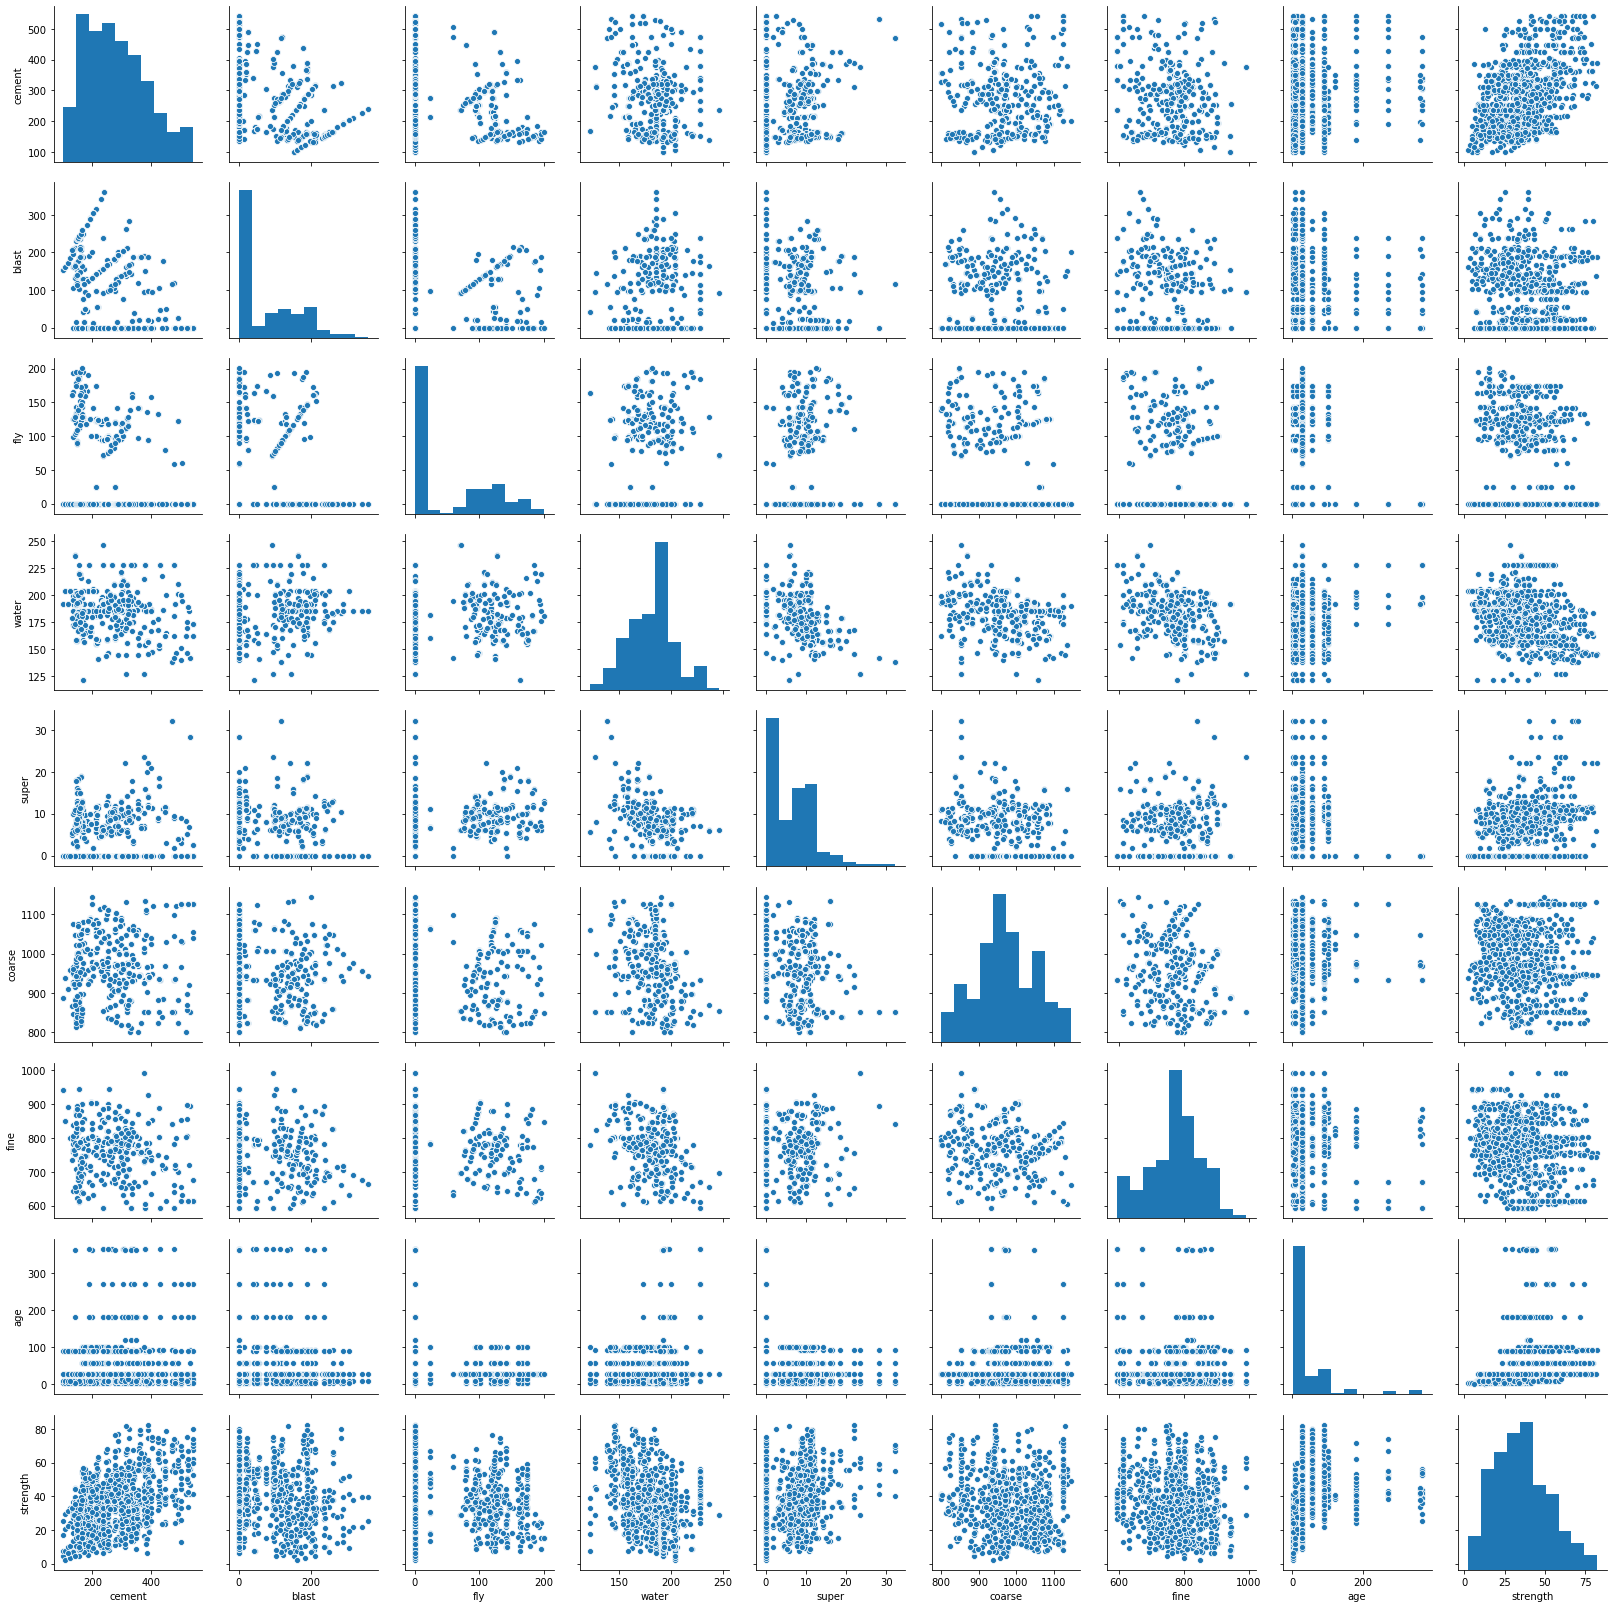

In [19]:
#seaborn.sns
sns.pairplot(df)

#### 데이터를 입출력 Train, Test 데이터 추출한다.

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1) #test size 10%
X_train.shape

(927, 8)

#### optimizer설정

In [57]:
lr = 0.001
#opt = optimizers.SGD(lr=lr, clipvalue=0.5)
opt = optimizers.Adam(lr=lr, clipvalue=0.5)

### 모델을 만든다.
#### regression이므로 accuracy는 필요없다. 
#### Hyperparameter optimization에서는 loss finc을 최소화하는 값을 Goal로 설정한다
#### HP : optimizer, epochs

In [58]:
model =Sequential()
model.add(Dense(256, activation='relu', input_shape=(8,))) #feature는 8개
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mse', optimizer =opt) ##regression은 accuracy가 의미 없다. 
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 256)               2304      
_________________________________________________________________
dense_22 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_23 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 33        
Total params: 39,361
Trainable params: 39,361
Non-trainable params: 0
_________________________________________________________________


### Training
#### MSE loss를 본다.

In [59]:
hist= model.fit(X_train, Y_train, epochs=400, validation_split=0.1)

Epoch 1/400
27/27 [==============================] - 0s 3ms/step - loss: 1410.9301 - val_loss: 1085.4874
Epoch 2/400
27/27 [==============================] - 0s 2ms/step - loss: 535.5358 - val_loss: 275.6354
Epoch 3/400
27/27 [==============================] - 0s 2ms/step - loss: 240.7729 - val_loss: 194.3807
Epoch 4/400
27/27 [==============================] - 0s 2ms/step - loss: 184.5012 - val_loss: 158.7007
Epoch 5/400
27/27 [==============================] - 0s 2ms/step - loss: 151.0579 - val_loss: 131.9431
Epoch 6/400
27/27 [==============================] - 0s 2ms/step - loss: 131.9969 - val_loss: 126.3891
Epoch 7/400
27/27 [==============================] - 0s 2ms/step - loss: 121.6564 - val_loss: 119.4002
Epoch 8/400
27/27 [==============================] - 0s 1ms/step - loss: 117.7491 - val_loss: 117.2664
Epoch 9/400
27/27 [==============================] - 0s 1ms/step - loss: 117.3467 - val_loss: 118.3832
Epoch 10/400
27/27 [==============================] - 0s 2ms/step - los

27/27 [==============================] - 0s 1ms/step - loss: 33.4639 - val_loss: 47.7291
Epoch 82/400
27/27 [==============================] - 0s 2ms/step - loss: 33.2256 - val_loss: 48.8821
Epoch 83/400
27/27 [==============================] - 0s 1ms/step - loss: 33.2336 - val_loss: 37.2163
Epoch 84/400
27/27 [==============================] - 0s 2ms/step - loss: 32.8622 - val_loss: 37.7734
Epoch 85/400
27/27 [==============================] - 0s 1ms/step - loss: 30.9172 - val_loss: 39.3380
Epoch 86/400
27/27 [==============================] - 0s 1ms/step - loss: 31.6244 - val_loss: 37.9605
Epoch 87/400
27/27 [==============================] - 0s 1ms/step - loss: 31.6732 - val_loss: 39.5266
Epoch 88/400
27/27 [==============================] - 0s 1ms/step - loss: 32.2675 - val_loss: 48.5159
Epoch 89/400
27/27 [==============================] - 0s 1ms/step - loss: 32.1486 - val_loss: 37.8136
Epoch 90/400
27/27 [==============================] - 0s 1ms/step - loss: 31.6776 - val_loss: 3

Epoch 161/400
27/27 [==============================] - 0s 2ms/step - loss: 21.1050 - val_loss: 27.2746
Epoch 162/400
27/27 [==============================] - 0s 1ms/step - loss: 21.3040 - val_loss: 29.4902
Epoch 163/400
27/27 [==============================] - 0s 1ms/step - loss: 21.2446 - val_loss: 33.0421
Epoch 164/400
27/27 [==============================] - 0s 1ms/step - loss: 21.4061 - val_loss: 25.4610
Epoch 165/400
27/27 [==============================] - 0s 1ms/step - loss: 18.9793 - val_loss: 25.0980
Epoch 166/400
27/27 [==============================] - 0s 1ms/step - loss: 20.7045 - val_loss: 23.7650
Epoch 167/400
27/27 [==============================] - 0s 2ms/step - loss: 20.2407 - val_loss: 33.2070
Epoch 168/400
27/27 [==============================] - 0s 1ms/step - loss: 22.5896 - val_loss: 28.4876
Epoch 169/400
27/27 [==============================] - 0s 1ms/step - loss: 21.6533 - val_loss: 29.3971
Epoch 170/400
27/27 [==============================] - 0s 1ms/step - loss

27/27 [==============================] - 0s 1ms/step - loss: 14.9921 - val_loss: 40.1052
Epoch 241/400
27/27 [==============================] - 0s 1ms/step - loss: 19.9139 - val_loss: 24.3755
Epoch 242/400
27/27 [==============================] - 0s 1ms/step - loss: 15.8964 - val_loss: 23.7347
Epoch 243/400
27/27 [==============================] - 0s 2ms/step - loss: 15.3547 - val_loss: 28.7140
Epoch 244/400
27/27 [==============================] - 0s 1ms/step - loss: 15.9245 - val_loss: 25.5120
Epoch 245/400
27/27 [==============================] - 0s 1ms/step - loss: 15.6172 - val_loss: 24.3920
Epoch 246/400
27/27 [==============================] - 0s 1ms/step - loss: 16.5740 - val_loss: 25.1082
Epoch 247/400
27/27 [==============================] - 0s 1ms/step - loss: 14.9190 - val_loss: 24.1058
Epoch 248/400
27/27 [==============================] - 0s 1ms/step - loss: 15.6265 - val_loss: 28.6044
Epoch 249/400
27/27 [==============================] - 0s 1ms/step - loss: 15.5419 - va

27/27 [==============================] - 0s 2ms/step - loss: 12.6891 - val_loss: 25.5644
Epoch 320/400
27/27 [==============================] - 0s 2ms/step - loss: 12.7584 - val_loss: 23.2927
Epoch 321/400
27/27 [==============================] - 0s 1ms/step - loss: 12.5242 - val_loss: 24.6891
Epoch 322/400
27/27 [==============================] - 0s 1ms/step - loss: 12.7264 - val_loss: 25.4053
Epoch 323/400
27/27 [==============================] - 0s 2ms/step - loss: 13.7912 - val_loss: 29.1316
Epoch 324/400
27/27 [==============================] - 0s 2ms/step - loss: 12.8629 - val_loss: 21.6169
Epoch 325/400
27/27 [==============================] - 0s 1ms/step - loss: 12.7750 - val_loss: 29.1441
Epoch 326/400
27/27 [==============================] - 0s 1ms/step - loss: 14.1208 - val_loss: 25.3140
Epoch 327/400
27/27 [==============================] - 0s 2ms/step - loss: 12.8501 - val_loss: 24.0179
Epoch 328/400
27/27 [==============================] - 0s 1ms/step - loss: 15.4697 - va

27/27 [==============================] - 0s 1ms/step - loss: 12.0454 - val_loss: 29.4681
Epoch 399/400
27/27 [==============================] - 0s 1ms/step - loss: 11.4043 - val_loss: 37.1197
Epoch 400/400
27/27 [==============================] - 0s 2ms/step - loss: 12.1369 - val_loss: 27.3778


#### 학습 loss 그래프 확인

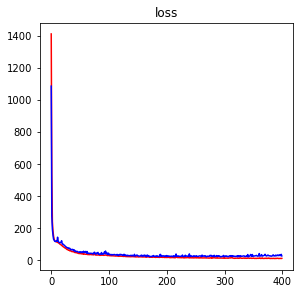

In [60]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 2)
plt.plot(hist.history['loss'], color='r')
plt.plot(hist.history['val_loss'], color='b')
plt.title('loss')
plt.show()

### Evaluate

In [61]:
score = model.evaluate(X_test, Y_test)
print(score)

4/4 [==============================] - 0s 938us/step - loss: 24.1737
24.173688888549805


### Predict

In [62]:
pred = model.predict(X_test[-5:])
print(X_test[-5:])
print('========Pred ratio')
print(pred)
print('========Real Y')
print(Y_test[-5:])

[[0.78538813 0.06677796 0.3948026  0.32135729 0.36149068 0.48255814
  0.29603613 0.07417582]
 [0.64611872 0.         0.         0.51297405 0.         0.47965116
  0.42398394 0.        ]
 [0.73744292 0.29577073 0.         0.25349301 0.51242236 0.14854651
  0.73532363 0.07417582]
 [0.58675799 0.05286589 0.70464768 0.25748503 0.33881988 0.40988372
  0.51931761 0.1510989 ]
 [0.07465753 0.         0.82808596 0.46666667 0.31055901 0.46511628
  0.52910186 0.07417582]]
========Pred ratio
[[56.03839 ]
 [14.387728]
 [60.95714 ]
 [68.52508 ]
 [12.937454]]
========Real Y
472    44.422939
763     6.267337
126    60.294676
530    66.780675
968    13.293787
Name: strength, dtype: float64
